In [1]:
from datetime import date
from glob import glob
import os, sys
from os.path import join, dirname
from tqdm import tqdm

import pickle as pkl
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.stats.multitest

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm, colors

from scipy import optimize, stats

import nilearn
from nilearn import plotting
from nilearn import masking
from nilearn.input_data import NiftiLabelsMasker

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

# import pingouin as pg

import random
# from random import random as rand

import re

/home/sungbeenpark/.local/lib/python3.10/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [2]:
%matplotlib inline

In [3]:
def fast_masking(img, roi):
    ## img : data (NIFTI image)
    img_data = img.get_fdata()
    roi_mask = roi.get_fdata().astype(bool)
    if img_data.shape != roi_mask.shape:
        raise ValueError('different shape while masking! img=%s and roi=%s' % (img_data.shape, roi_mask.shape))
    ## the shape is (n_trials, n_voxels) which is to cross-validate for runs. =(n_samples, n_features)
    return img_data[roi_mask]

In [4]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

In [5]:
dir_root = join('/mnt/ext5/GP/fmri_data')
dir_stat = join(dir_root, 'stats')
dir_mask = join(dir_root, 'masks')

In [6]:
list_dlPFC_cTBS = [
    '09', '10', '18', '21', '22'
    , '24', '27', '34', '35', '36'
    , '38', '42', '57', '59', '62'
    , '66', '67'
]
list_M1_cTBS = [
    '08', '11', '17', '19', '20'
    , '26', '32', '33', '37', '39'
    , '40', '41', '56', '58', '61'
    , '63', '65'
]
list_dlPFC_20Hz = [
    '43', '44', '45', '46', '47'
    , '48', '49', '50', '51', '53'
    , '54', '55'
]

In [7]:
bg_img = join('/usr/local/afni/abin/MNI152_2009_template.nii.gz')

---
---

In [8]:
glm, stat = 'GLM.reward_per_trial', 'Rew'
shift = 5
thresh = stats.norm.isf(0.5e-3) # p=1.e-3
# thresh = stats.norm.isf(0.5e-4) # p=1.e-4
# thresh = stats.norm.isf(0.5e-5) # p=1.e-5

/usr/local/fsl/lib/python3.10/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



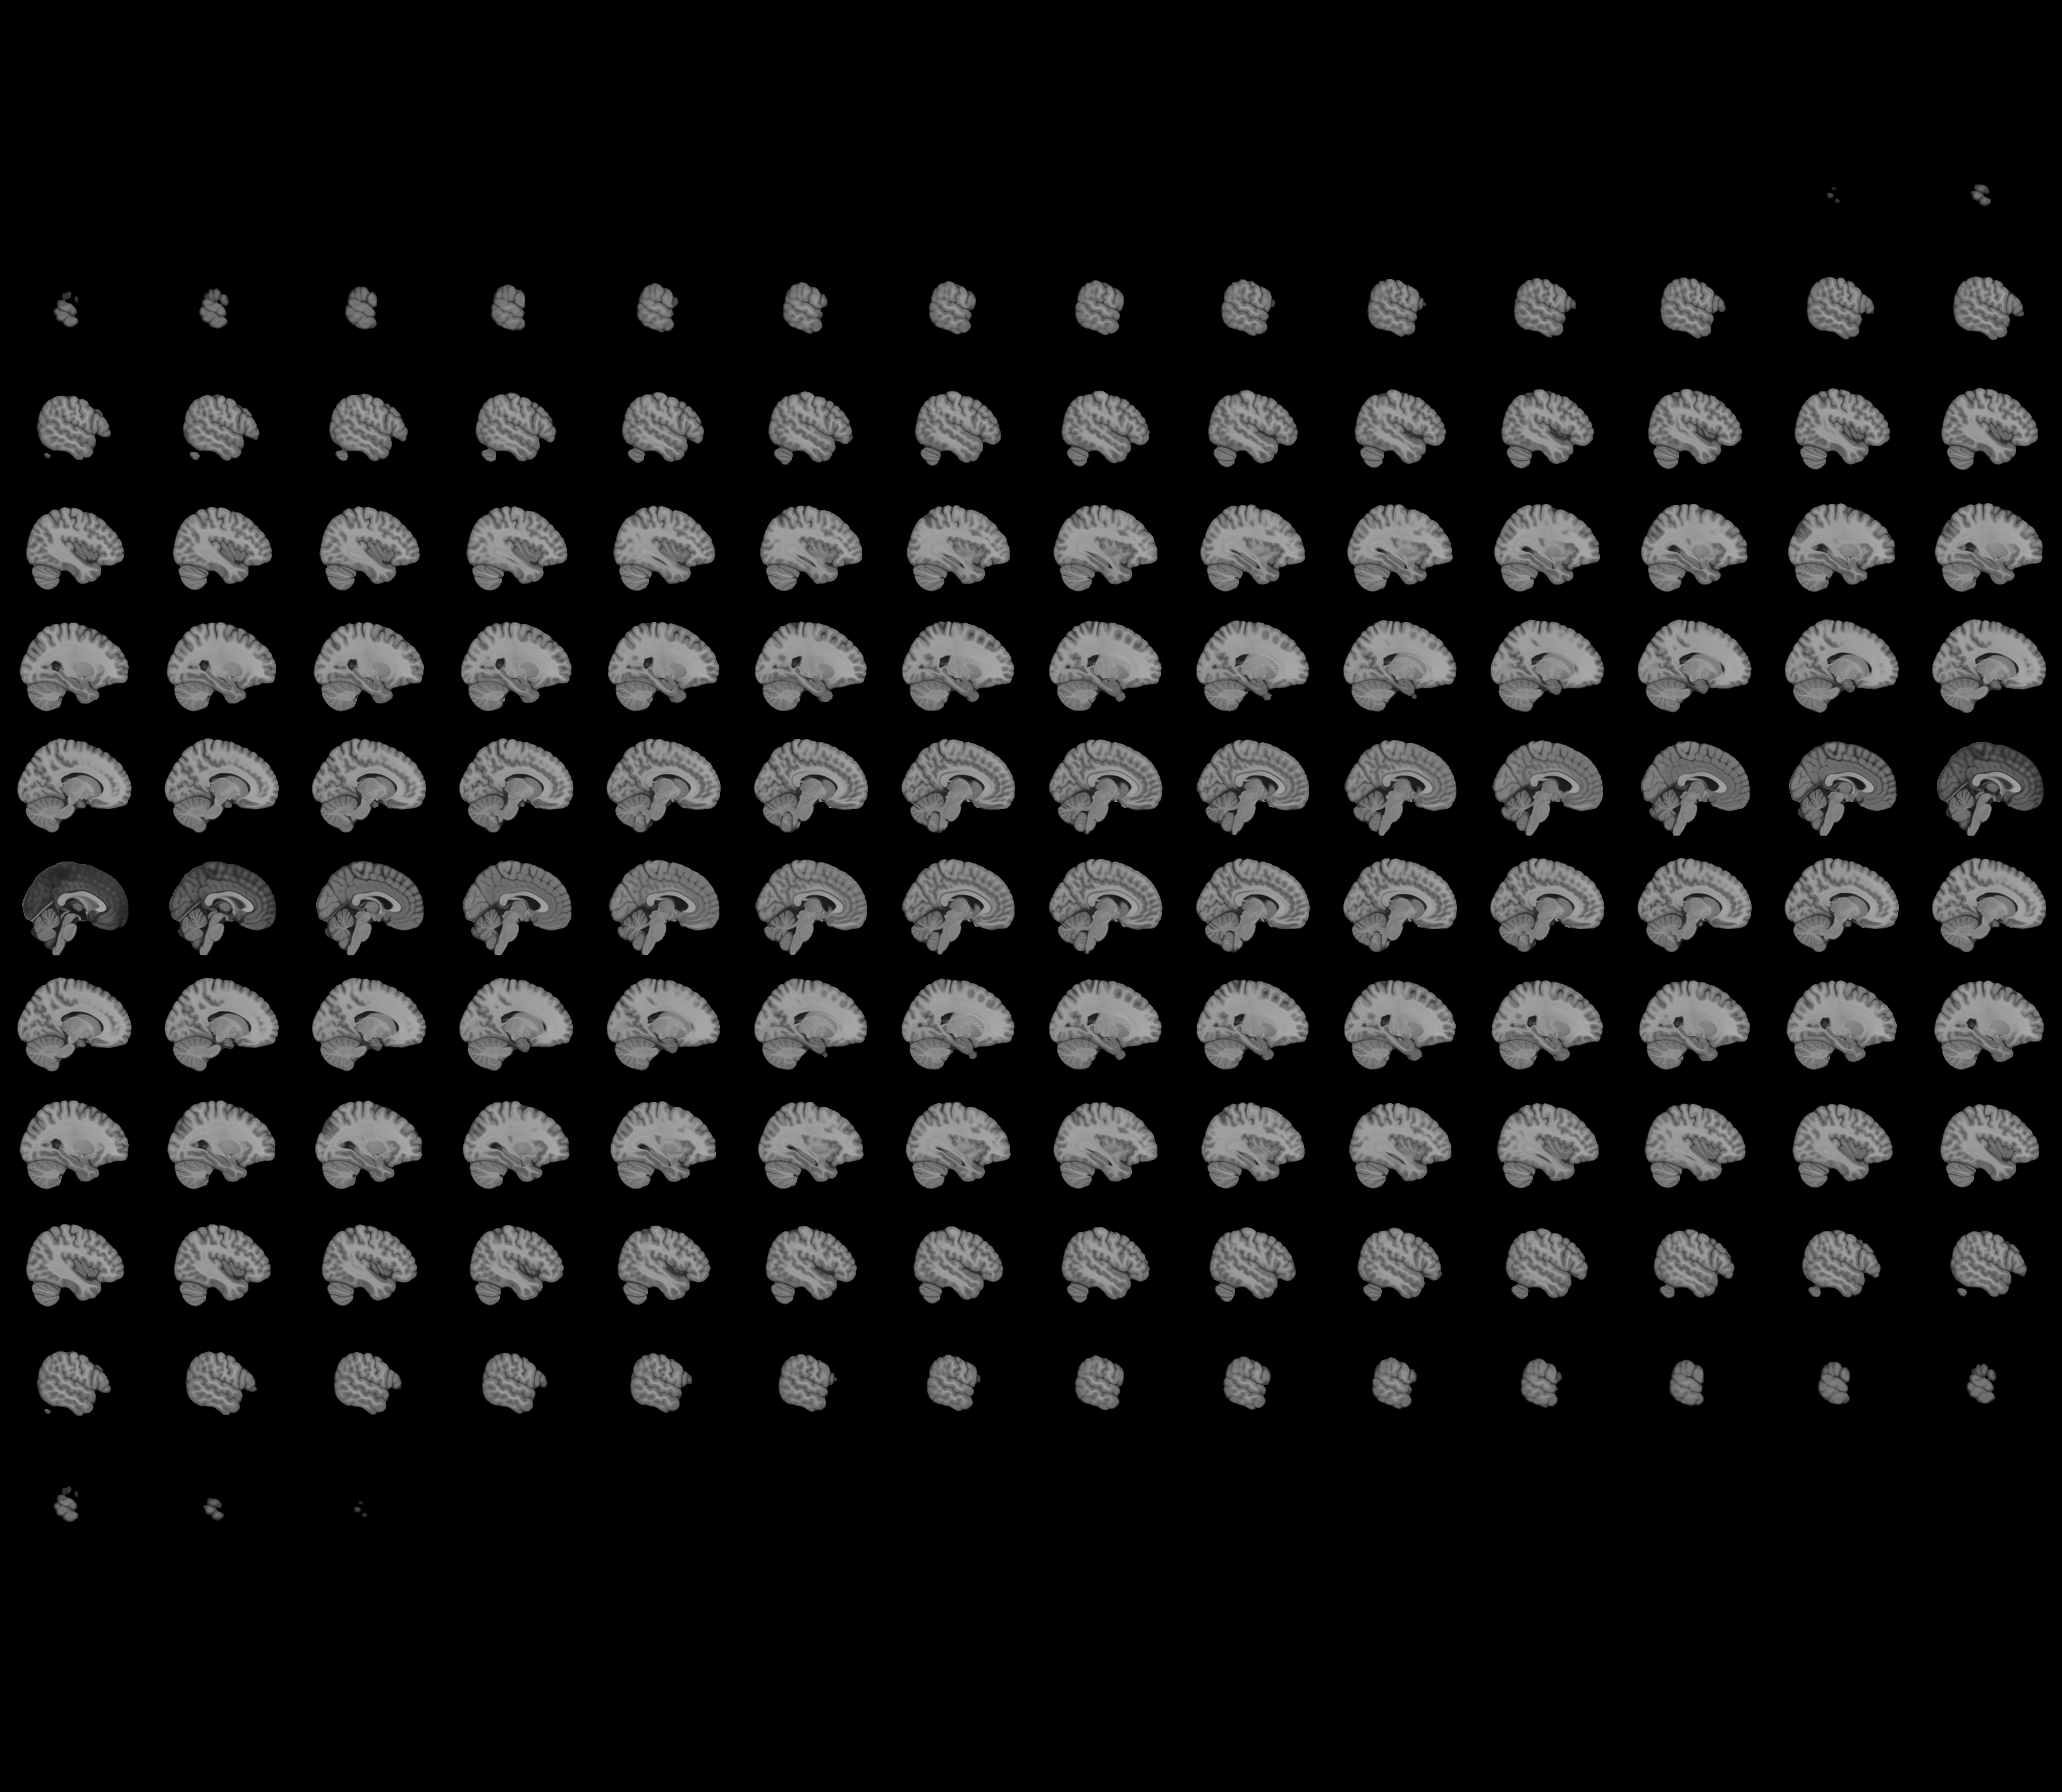
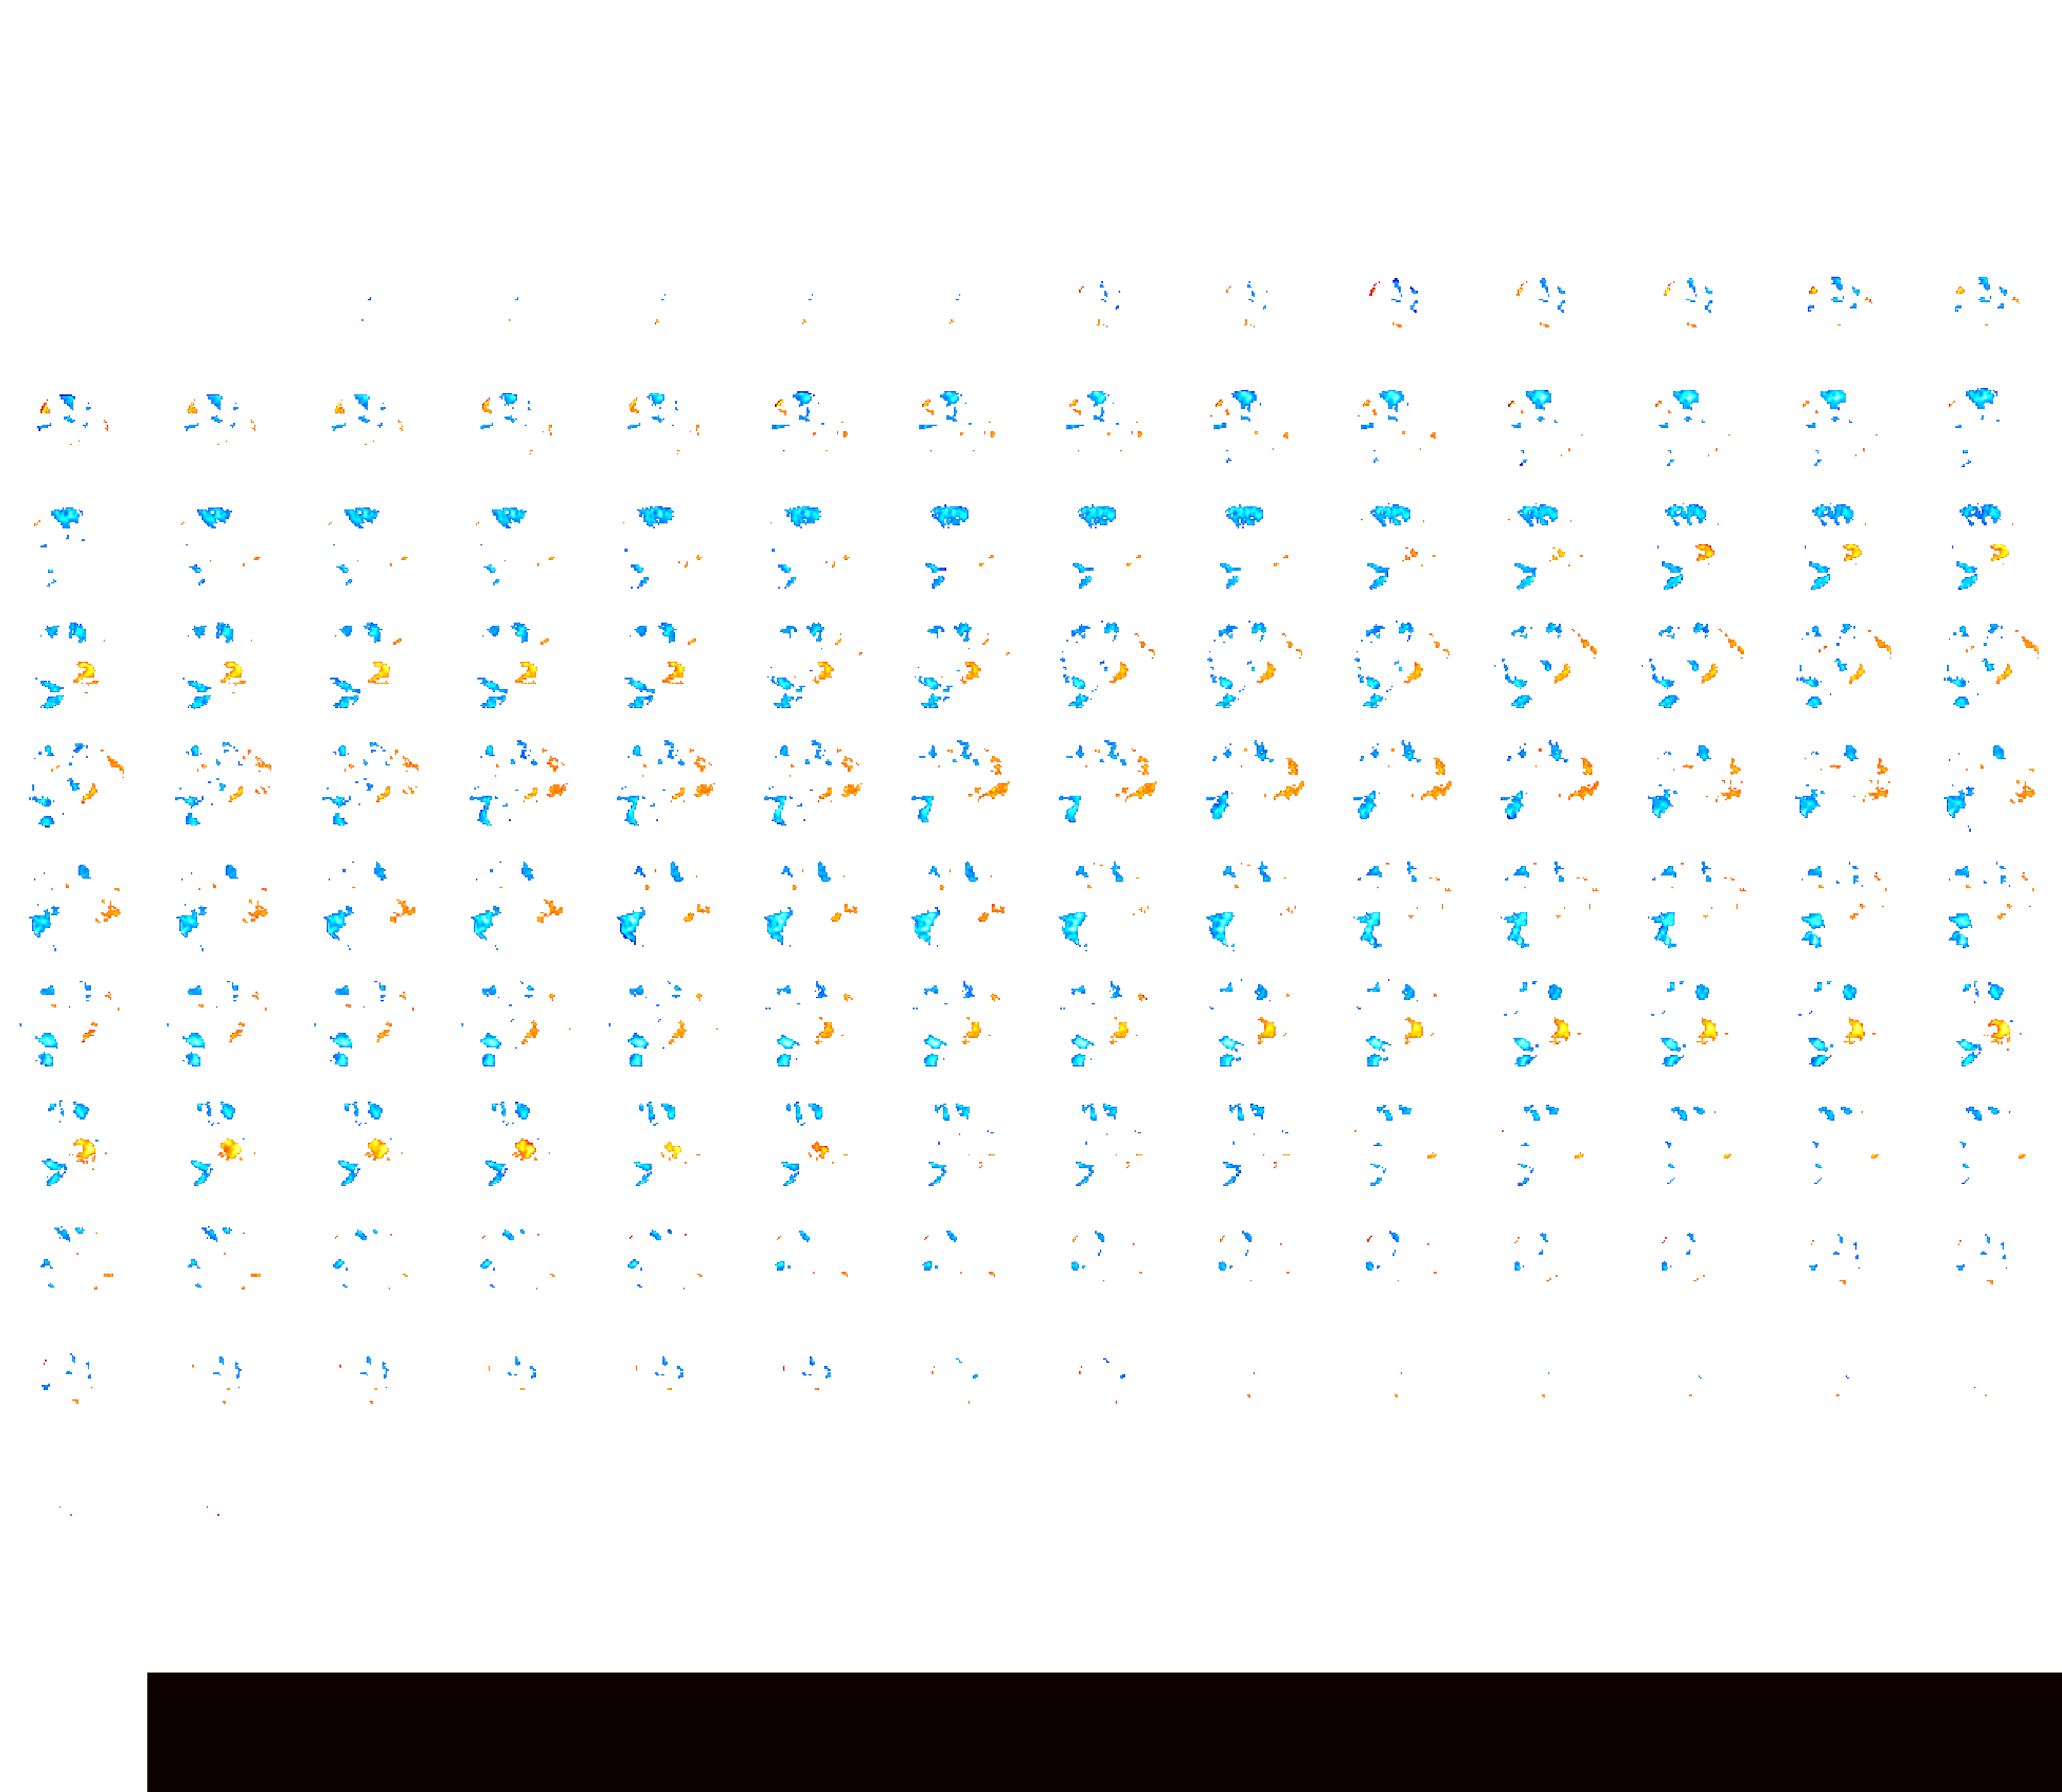

In [9]:
group = 'dlPFC_cTBS'
fname_Zscr = glob(join(dir_stat, 'AM/%s/%.1fs_shifted/GP.%s.Zscr.n??.nii'%(glm, shift, group)))[0]

nilearn.plotting.view_img(
    fname_Zscr
    , threshold=thresh
)

/usr/local/fsl/lib/python3.10/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



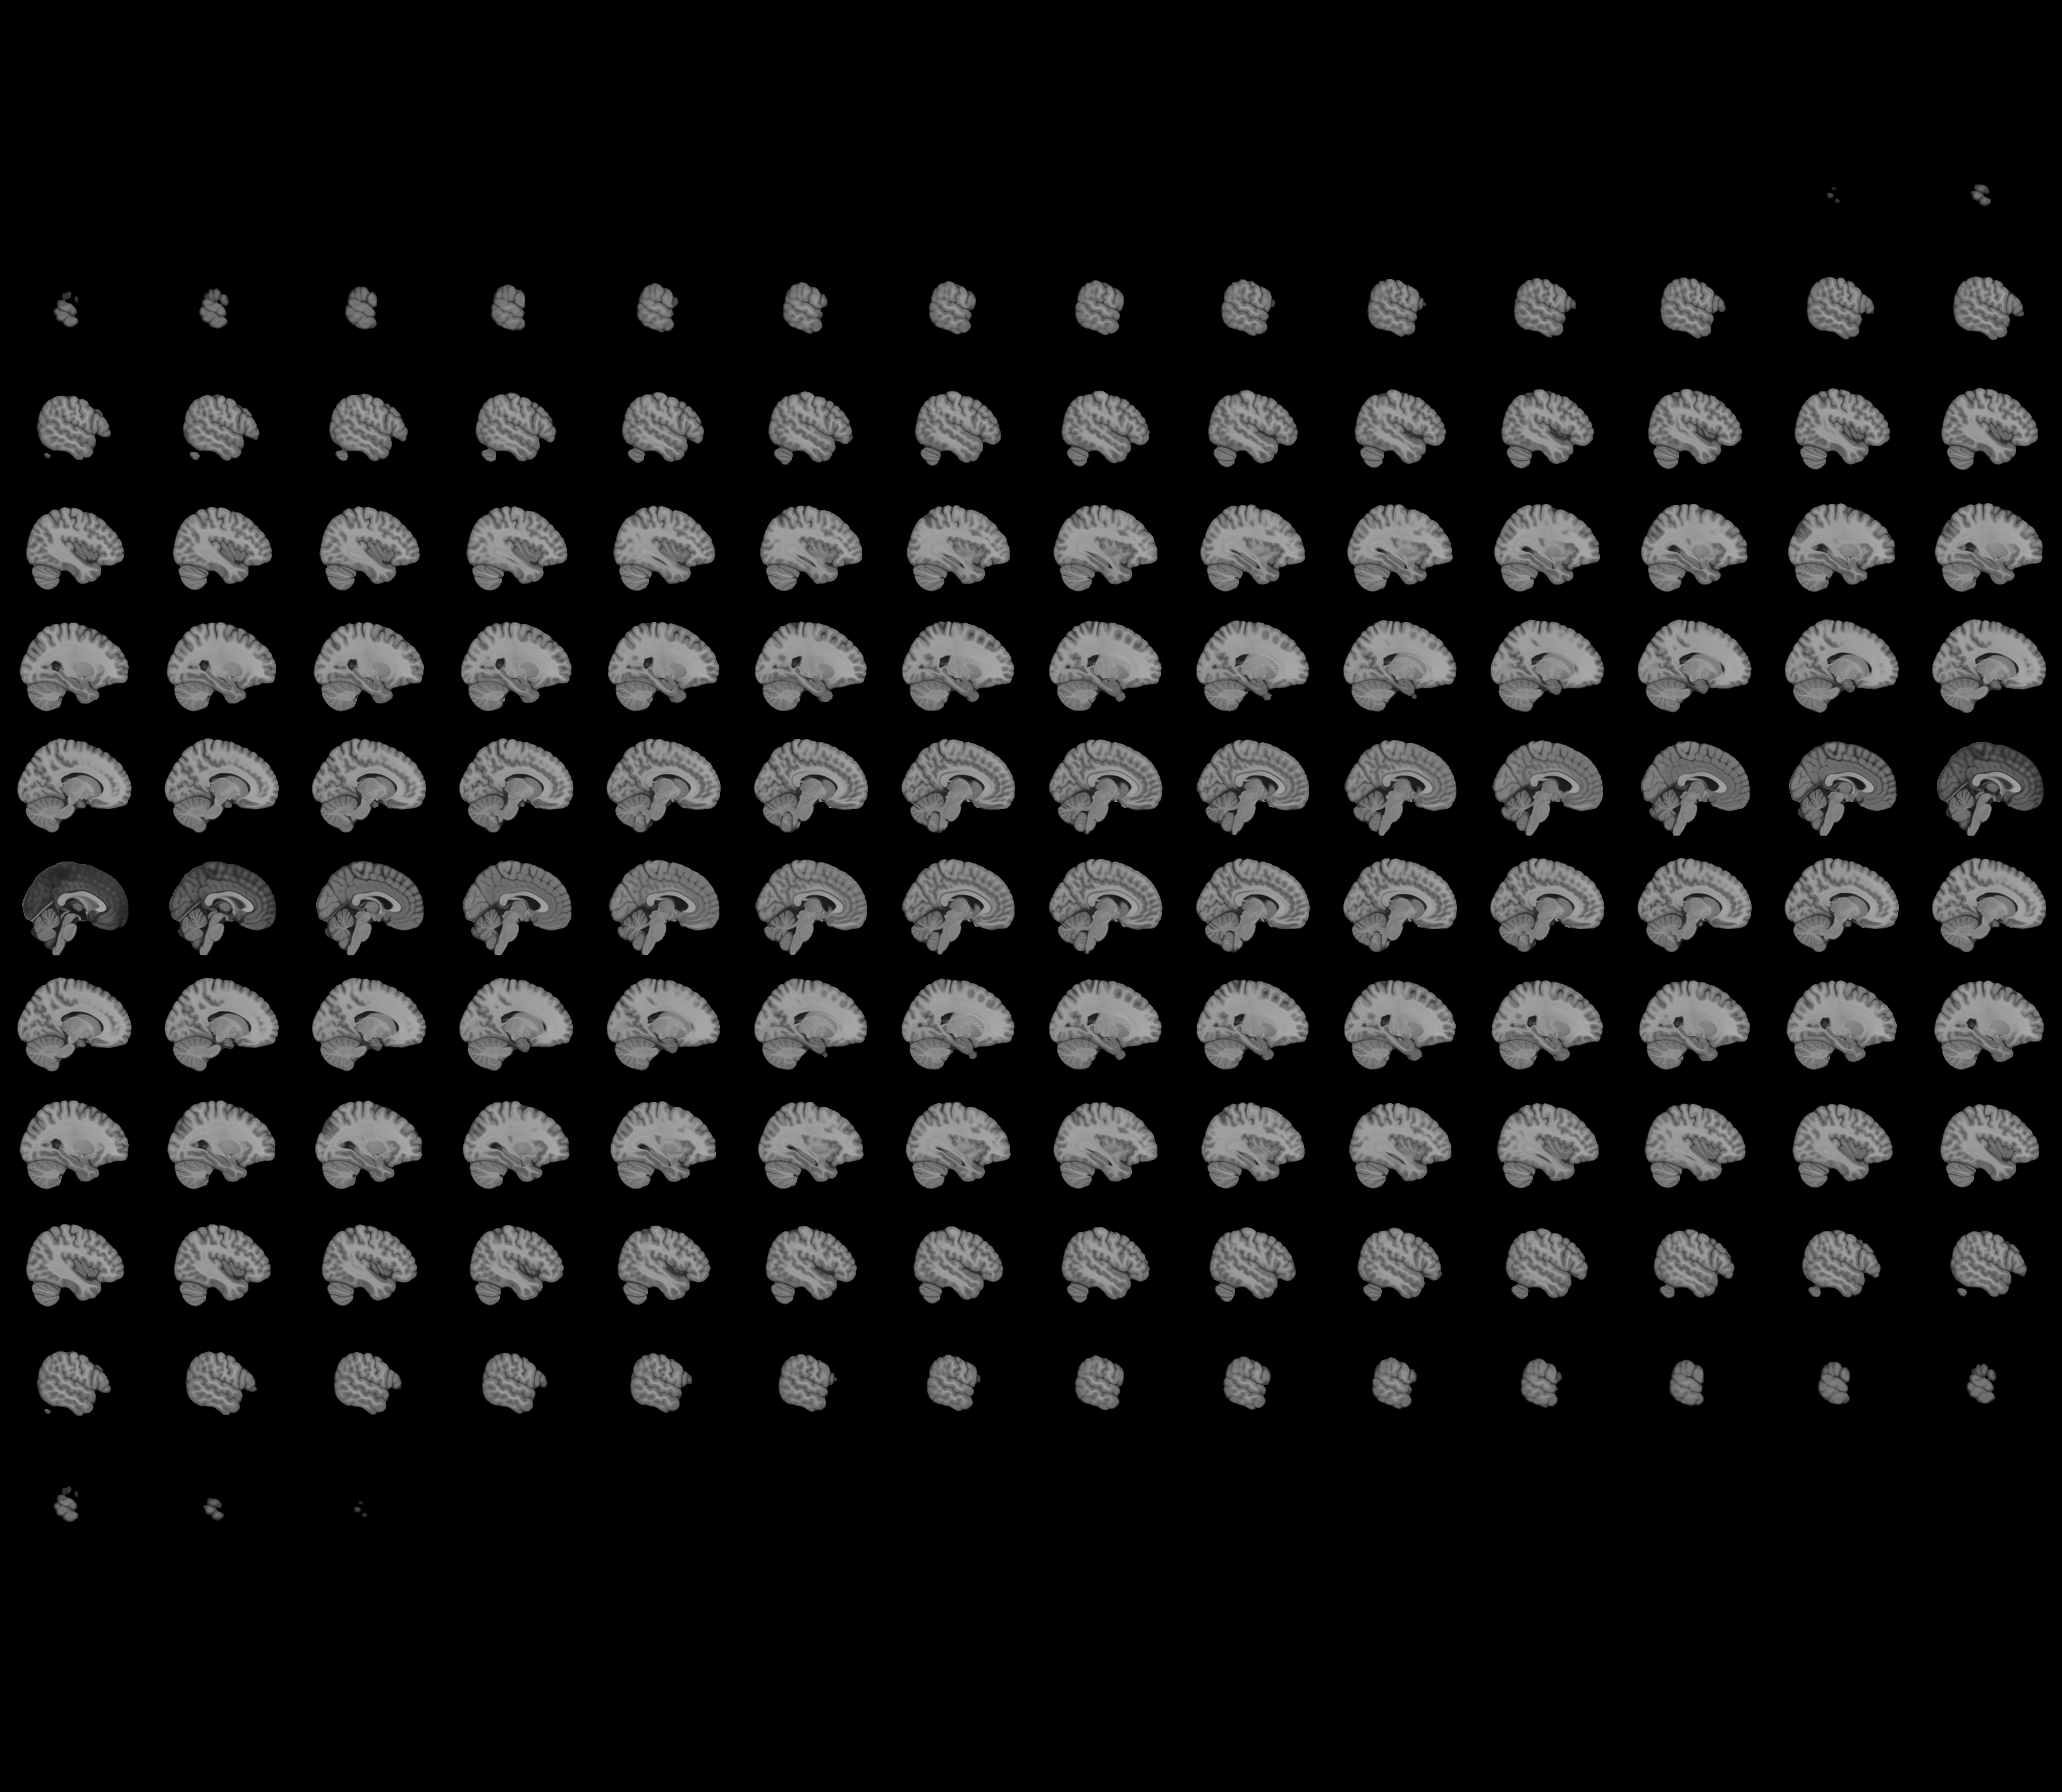
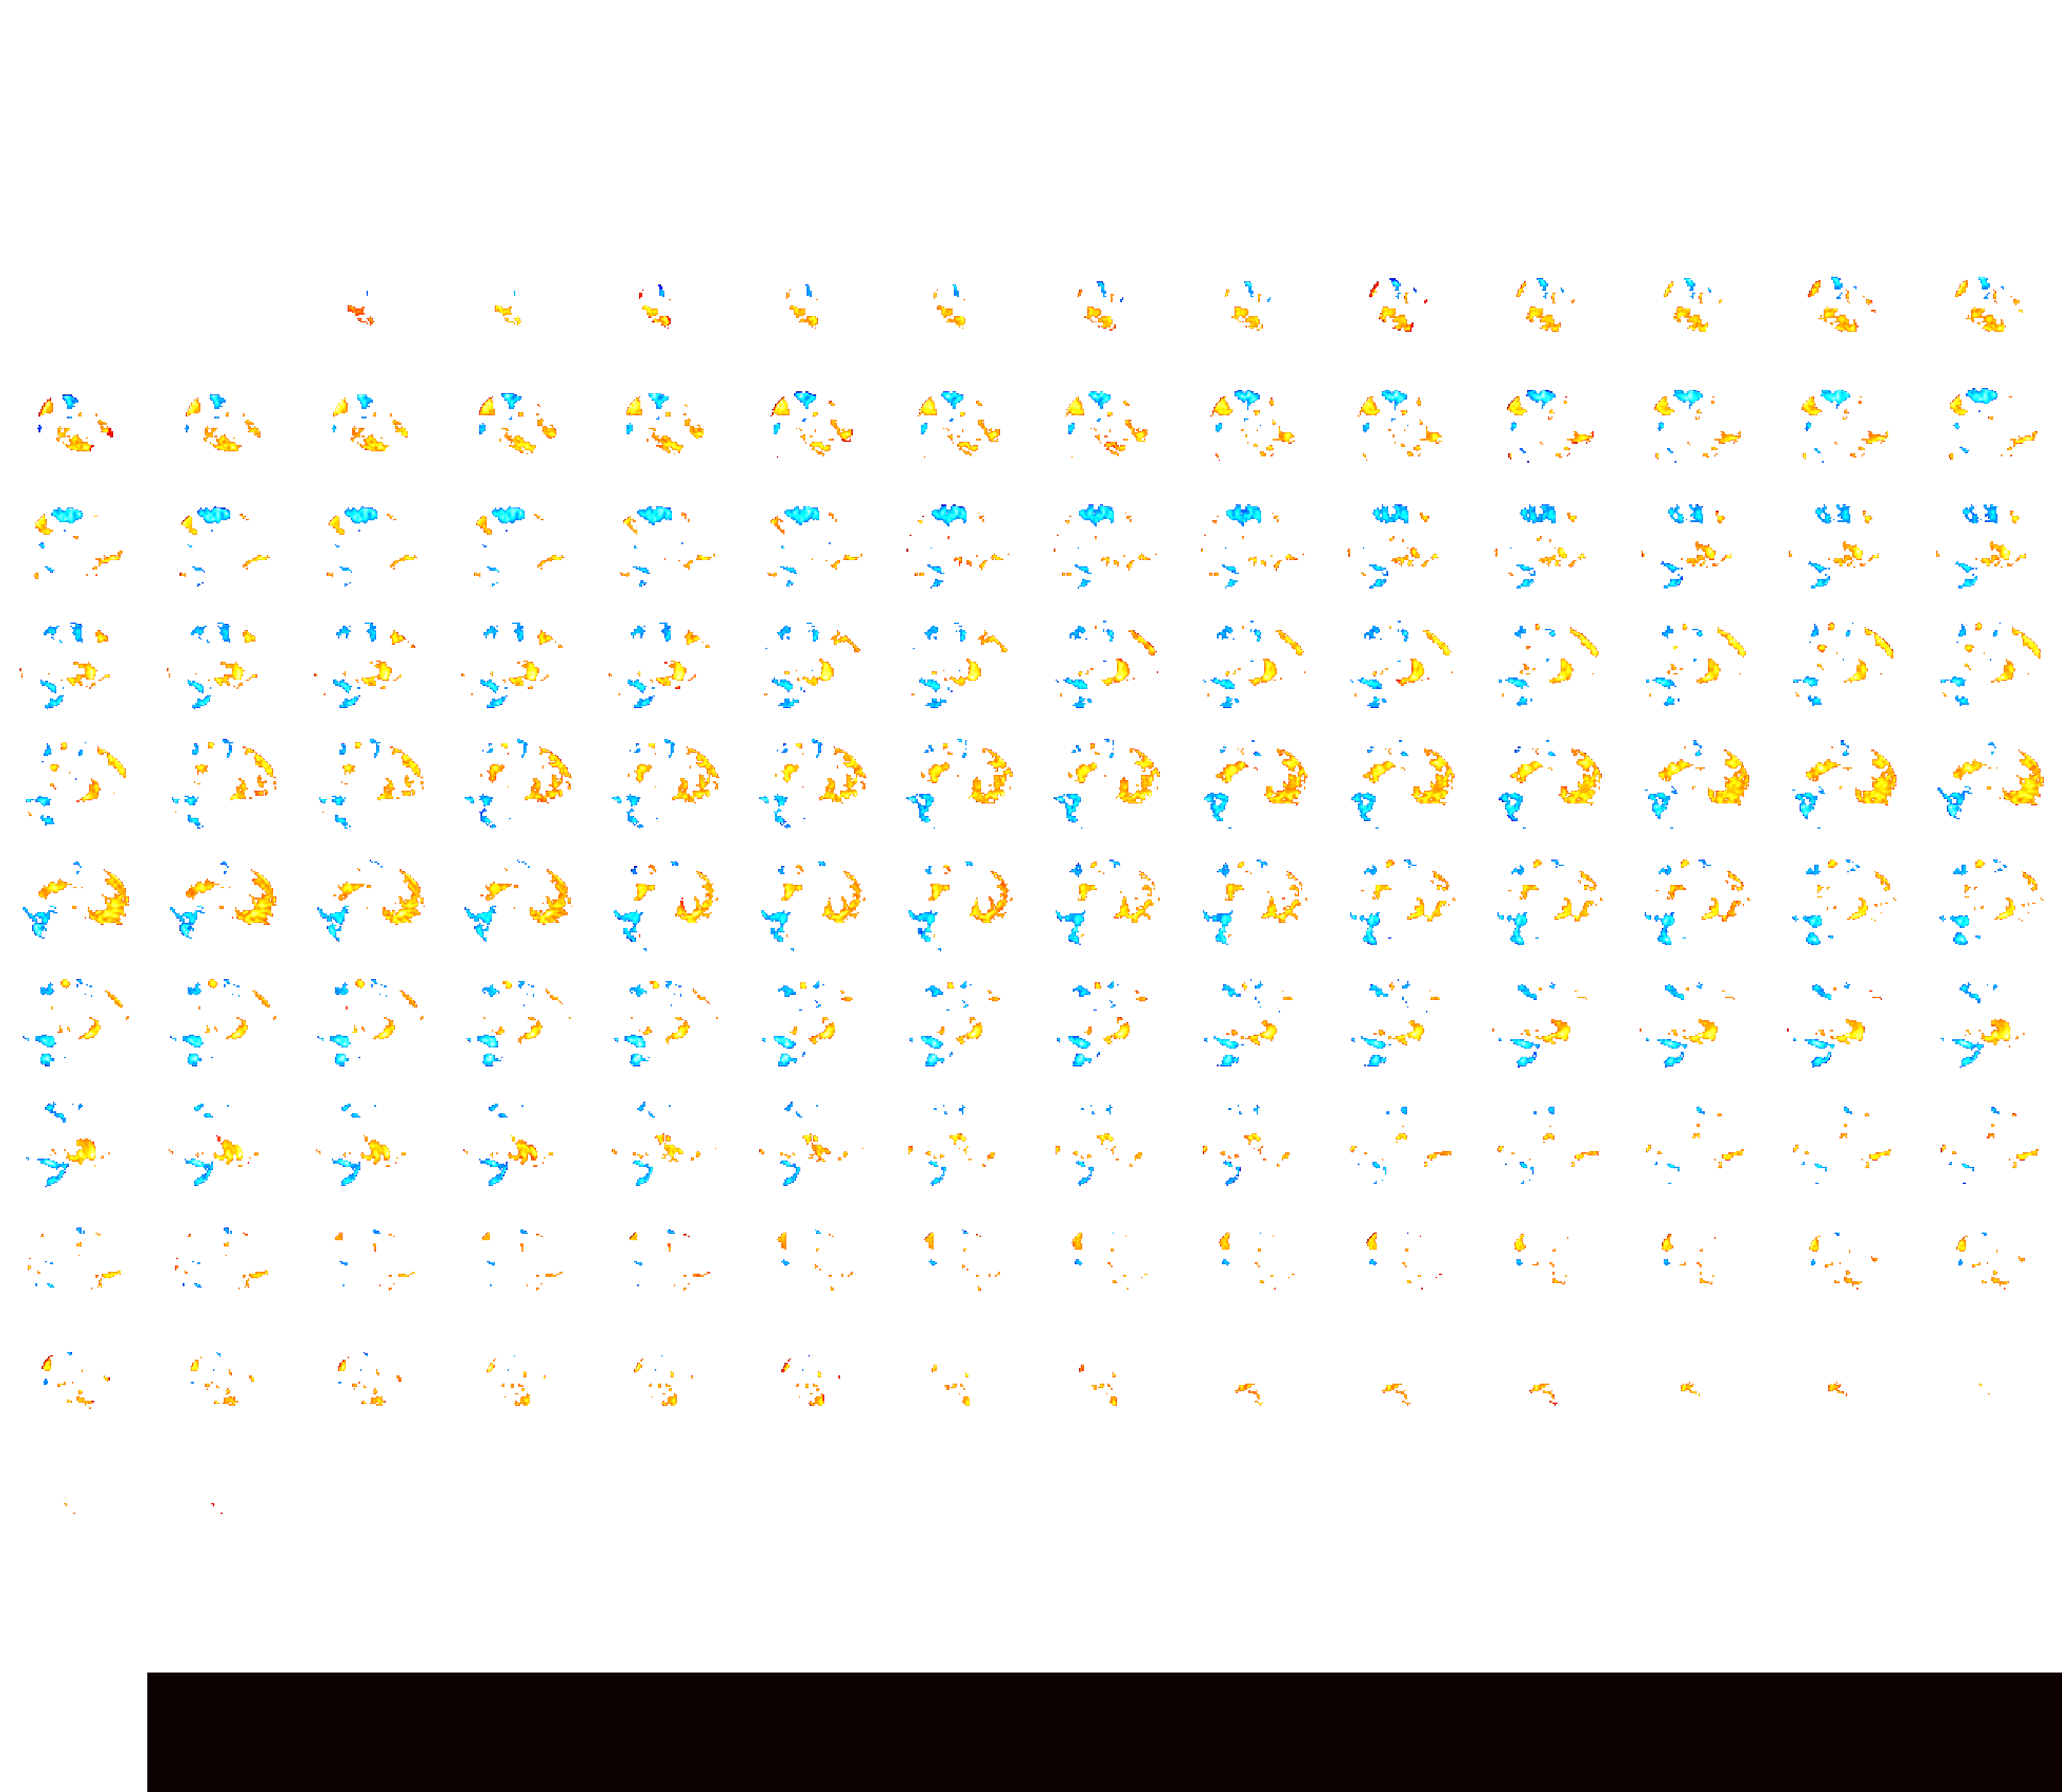

In [10]:
group = 'M1_cTBS'
fname_Zscr = glob(join(dir_stat, 'AM/%s/%.1fs_shifted/GP.%s.Zscr.n??.nii'%(glm, shift, group)))[0]

nilearn.plotting.view_img(
    fname_Zscr
    , threshold=thresh
)

In [ ]:
view_cut = {}
view_cut['sagittal'] = [-55, -22, -7, -3, 7, 22, 55]
view_cut['axial'] = [-14, -7, 2, 10, 35, 49, 57]

---

/tmp/ipykernel_137508/1688133774.py:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


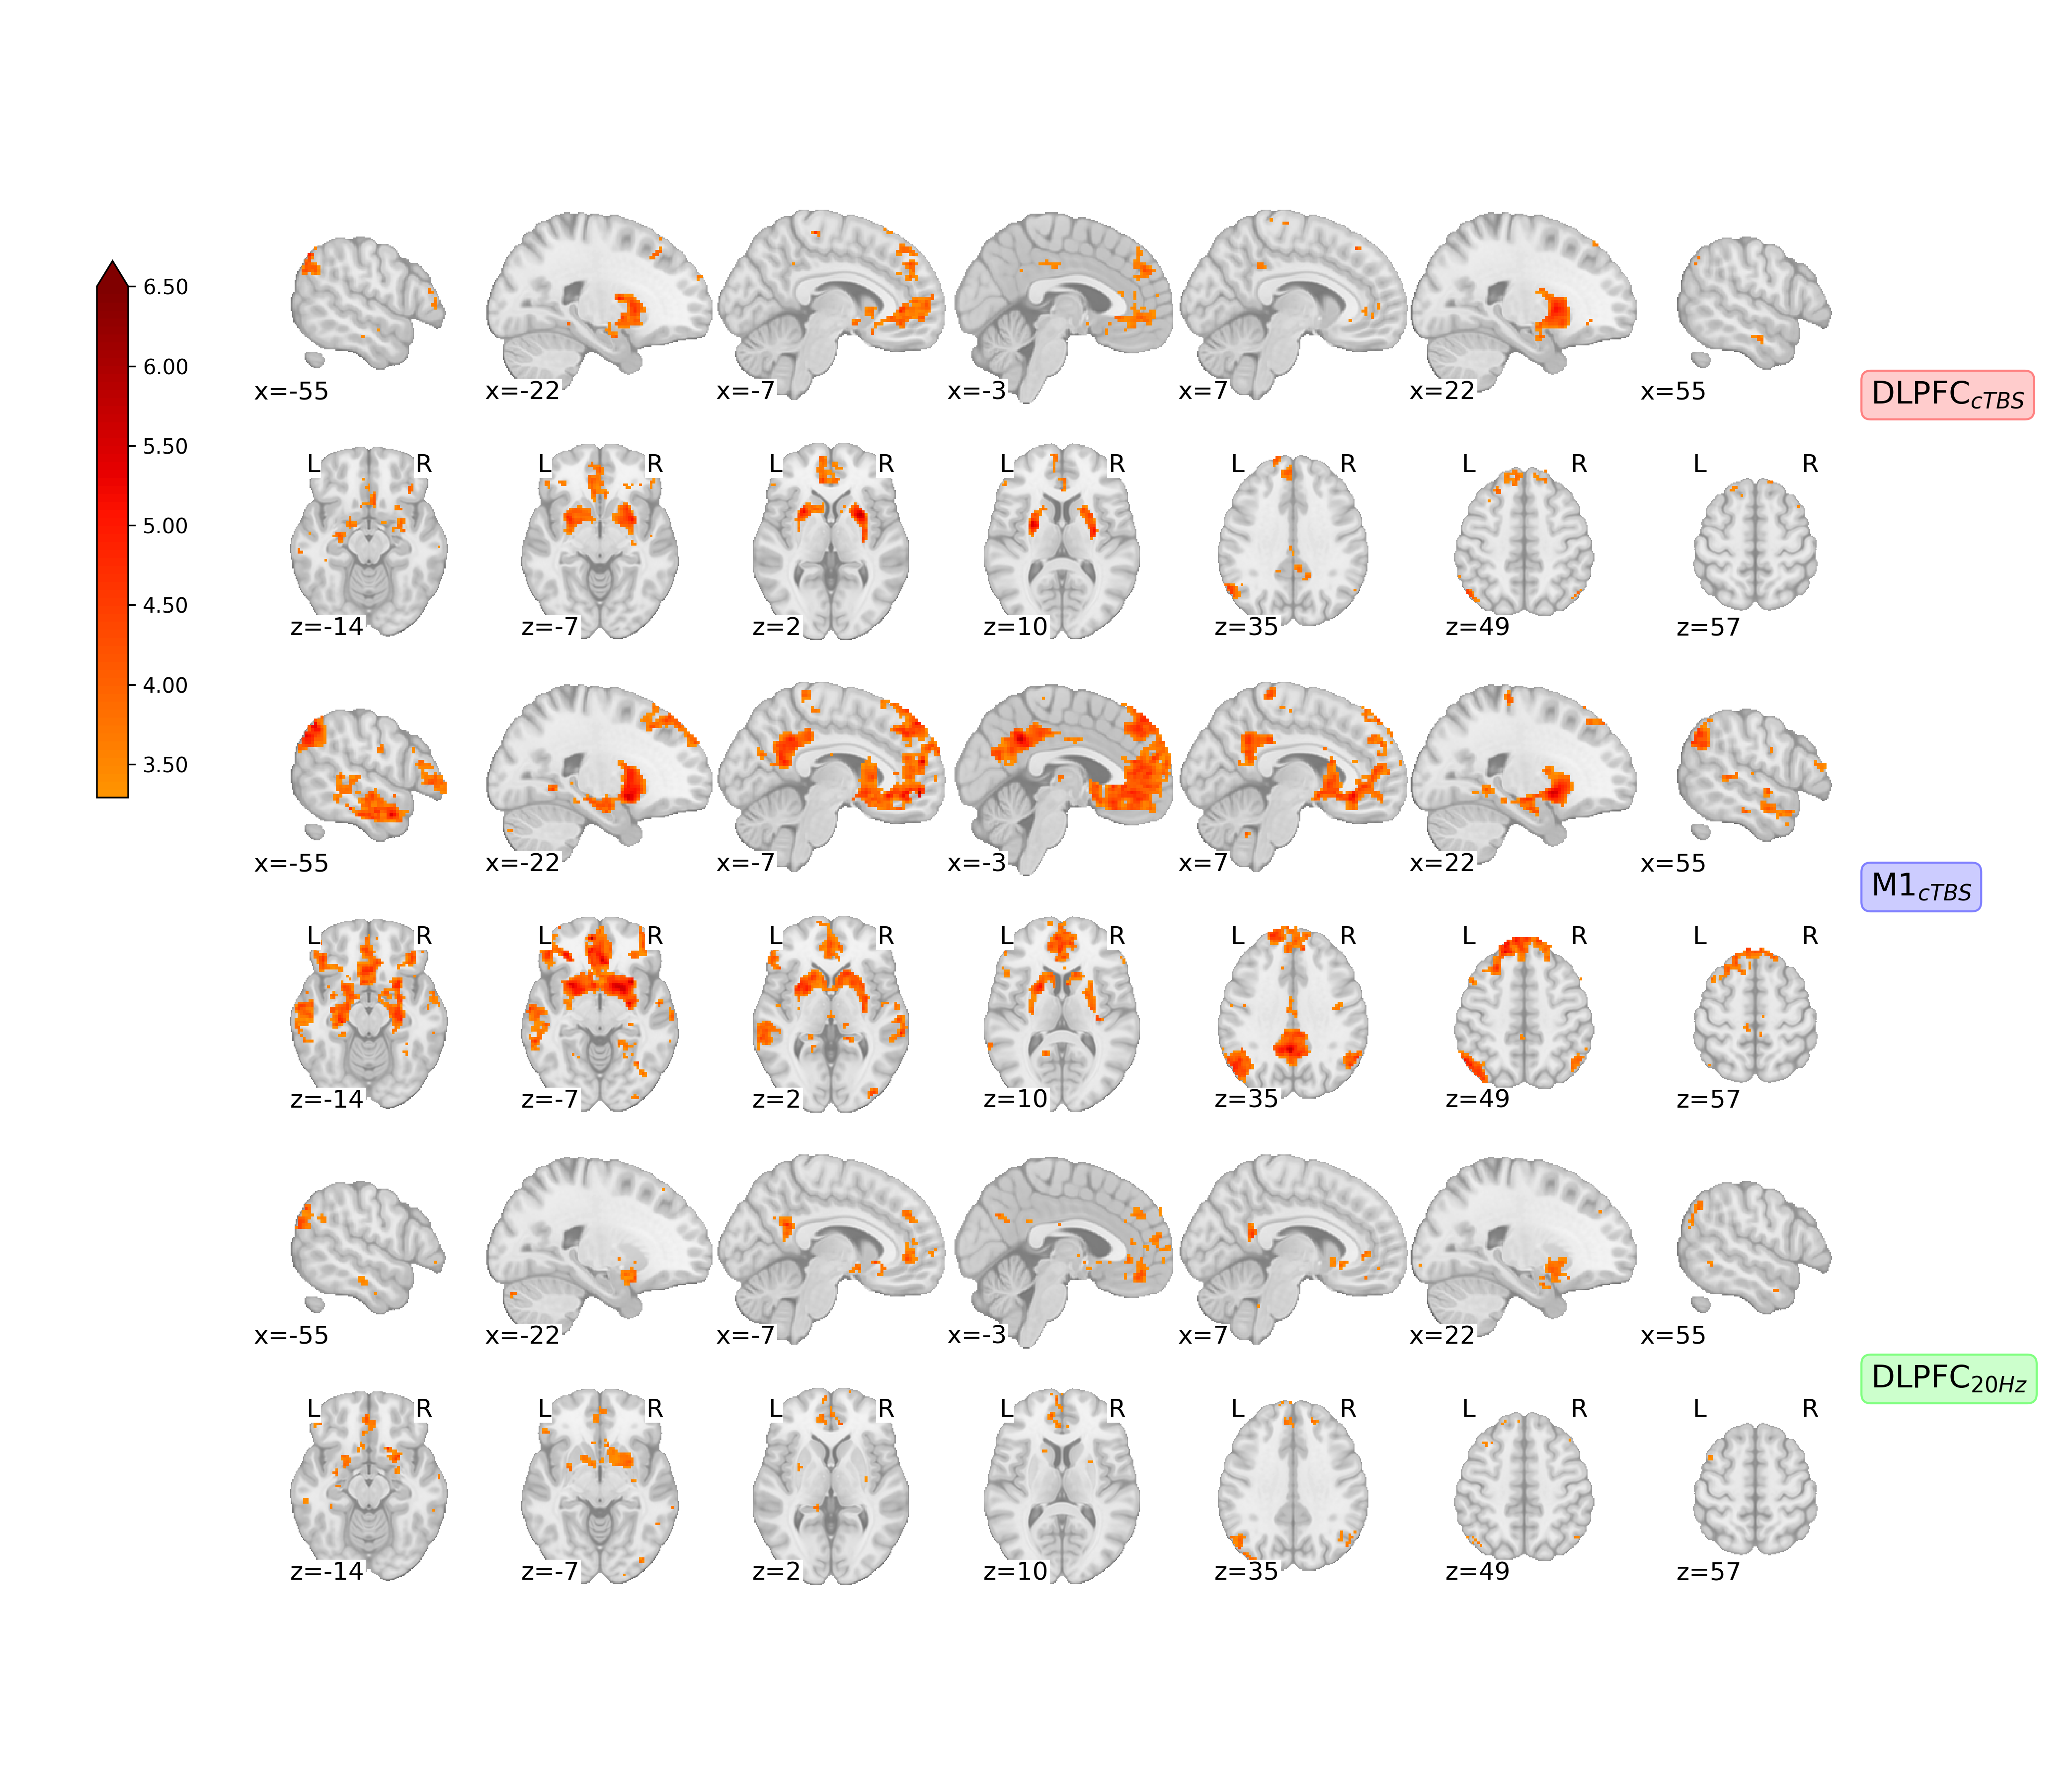

In [13]:
fig, axs = plt.subplots(nrows=6, ncols=1, figsize=(2*7,4*3), dpi=300)


for ii, group in enumerate(['dlPFC_cTBS', 'M1_cTBS', 'dlPFC_20Hz']):
    for jj, (axis, coord) in enumerate(view_cut.items()):
        ax = axs[ii*2+jj]
        fname_Zscr = glob(join(dir_stat, 'AM/%s/%.1fs_shifted/GP.%s.Zscr.n??.nii'%(glm, shift, group)))[0]
        
        ## positive
        img_stat = nilearn.image.math_img(
            img1=fname_Zscr
            , formula='(img1>0) * img1'
        )
        
#         ## positive & negative
#         img_stat = fname_Zscr
        
        g = plotting.plot_stat_map(
            img_stat
            , threshold=thresh
            , display_mode='x' if axis=='sagittal' else 'z'
            , black_bg=False
            , cut_coords=coord
            , vmax=6.5
            , cmap='jet', colorbar=False
            , axes=ax
        )

## 최대 최소 설정
vmax = 6.5
vmin = -6.5
norm = colors.Normalize(vmin=vmin, vmax=vmax)

################
## upper cmap ##
################

### 컬러바 생성
array_cmap = cm.jet(range(cm.jet.N))[int(norm(thresh)*256):]
cmap_new = colors.ListedColormap(array_cmap)
colormapping = cm.ScalarMappable(
    norm=colors.Normalize(vmin=thresh, vmax=vmax)
    , cmap=cmap_new
)
### 컬러바 삽입
# cax = fig.add_axes([0.05, .15, .015, .7])
cax = fig.add_axes([0.05, 0.55, .015, 0.3])
cbar = fig.colorbar(
    colormapping, extend='max'
    , orientation='vertical'
    , format='%.2f'
    , cax=cax)

# ################
# ## lower cmap ##
# ################

# ### 컬러바 생성
# array_cmap = cm.jet(range(cm.jet.N))[:int(norm(-thresh)*256)]
# cmap_new = colors.ListedColormap(array_cmap)
# colormapping = cm.ScalarMappable(
#     norm=colors.Normalize(vmin=vmin, vmax=-thresh)
#     , cmap=cmap_new
# )
# ### 컬러바 삽입
# # cax = fig.add_axes([0.05, .15, .015, .7])
# cax = fig.add_axes([0.05, 0.15, .015, 0.3])
# cbar = fig.colorbar(
#     colormapping, extend='min'
#     , orientation='vertical'
#     , format='%.2f'
#     , cax=cax
# )

## titles
fig.text(
    0.9, 0.775, r'DLPFC$_{cTBS}$'
    , size=15, rotation=0
    , ha='left', va='center'
    , bbox=dict(
        boxstyle='round'
        , ec=(1., 0.5, 0.5)
        , fc=(1., 0.8, 0.8)
    )
)
fig.text(
    0.9, 0.5, r'M1$_{cTBS}$'
    , size=15, rotation=0
    , ha='left', va='center'
    , bbox=dict(
        boxstyle='round'
        , ec=(0.5, 0.5, 1)
        , fc=(0.8, 0.8, 1)
    )
)

fig.text(
    0.9, 0.225, r'DLPFC$_{20Hz}$'
    , size=15, rotation=0
    , ha='left', va='center'
    , bbox=dict(
        boxstyle='round'
        , ec=(0.5, 1, 0.5)
        , fc=(0.8, 1, 0.8)
    )
)

fig.tight_layout()

In [14]:
fig.savefig(
    '/home/sungbeenpark/Github/labs/GP/results/statmap.%s.Zscr.positive.png'%glm
    , dpi=300, facecolor=[1,1,1,1]
    , bbox_inches = "tight"
)

---

In [9]:
tmp = nilearn.image.load_img(join(dir_mask, "mask.sum.caudate_4parts.separated_putamen.resampled.nii"))
# img_roi_anterior = nilearn.image.math_img(img1=tmp, formula='(0<img1)&(img1<3)')
img_roi_anterior = nilearn.image.math_img(img1=tmp, formula='img1==2')

# img_roi_posterior = nilearn.image.math_img(img1=tmp, formula='img1>2')
img_roi_posterior = nilearn.image.math_img(img1=tmp, formula='img1==3')

# img_roi=join(dir_mask, 'mask.NN=1.clust0001.p=1.e-3.nii')

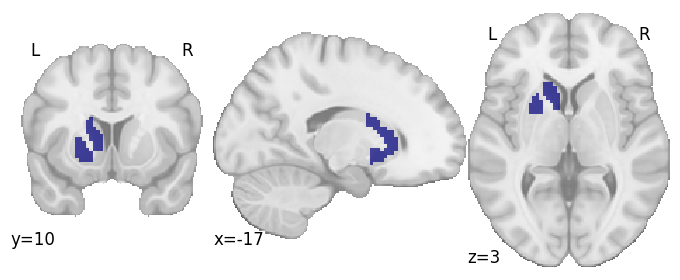

In [22]:
img_roi = img_roi_anterior
# img_roi = img_roi_posterior
nilearn.plotting.plot_roi(
    img_roi
    , display_mode='ortho', draw_cross=False
#     , cut_coords=[0, 40, 10]
)

In [24]:
## group data
a = glob(join(dir_stat, 'AM/%s/%.1fs_shifted/GP.dlPFC_cTBS.Zscr.n??.nii'%(glm, shift)))
b = glob(join(dir_stat, 'AM/%s/%.1fs_shifted/GP.M1_cTBS.Zscr.n??.nii'%(glm, shift)))
c = glob(join(dir_stat, 'AM/%s/%.1fs_shifted/GP.dlPFC_20Hz.Zscr.n??.nii'%(glm, shift)))
list_fname = np.concatenate([a,b,c])

df = pd.DataFrame(columns=['group', 'region', 'stim', 'roi', 'nvoxels', 'volume', 'pval', 'type', 'Z_thresh'])
pval = stats.norm.sf(thresh) * 2.

for ii, img_roi in enumerate([img_roi_anterior, img_roi_posterior]):
    roi = 'Anterior' if ii==0 else 'Posterior'
    for fname in list_fname:
        nn=fname.split('/')[-2][2:]
        region = 'DLPFC' if 'dlPFC' in fname else 'M1'
        stim = 'cTBS' if 'cTBS' in fname else '20Hz'
        raw = fname.split('/')[-1].split('.')[1].split('_')
        group = r'%s$_{%s}$'%(raw[0], raw[1])
        zscr = fast_masking(
            img=nilearn.image.load_img(fname)
            , roi=img_roi
        )
        nvoxels = zscr[zscr>thresh].shape[0]
        volume = 2.5**3 * nvoxels * 0.001
        new_row = pd.Series(
            {
                'group':group, 'region':region, 'stim':stim
                , 'roi':roi, 'nvoxels':nvoxels, 'volume':volume
                , 'pval':'%.4e'%pval, 'type':'two-tailed', 'Z_thresh':'%.4f'%(thresh)}
        )
        df = pd.concat(
            [df, new_row.to_frame().T]
            , axis='index'
            , ignore_index=True
        )
df

group region  stim        roi nvoxels    volume        pval  \
0  dlPFC$_{cTBS}$  DLPFC  cTBS   Anterior     190   2.96875  1.0000e-03   
1     M1$_{cTBS}$     M1  cTBS   Anterior     288       4.5  1.0000e-03   
2  dlPFC$_{20Hz}$  DLPFC  20Hz   Anterior      26   0.40625  1.0000e-03   
3  dlPFC$_{cTBS}$  DLPFC  cTBS  Posterior      46   0.71875  1.0000e-03   
4     M1$_{cTBS}$     M1  cTBS  Posterior      40     0.625  1.0000e-03   
5  dlPFC$_{20Hz}$  DLPFC  20Hz  Posterior       3  0.046875  1.0000e-03   

         type Z_thresh  
0  two-tailed   3.2905  
1  two-tailed   3.2905  
2  two-tailed   3.2905  
3  two-tailed   3.2905  
4  two-tailed   3.2905  
5  two-tailed   3.2905

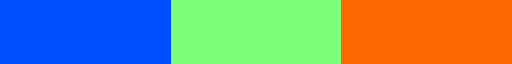

In [17]:
tmp = cm.jet(np.linspace(0.2, 0.8, 3))
palette = [colors.rgb2hex(rgb, keep_alpha=True) for rgb in tmp]

colors.ListedColormap(palette)

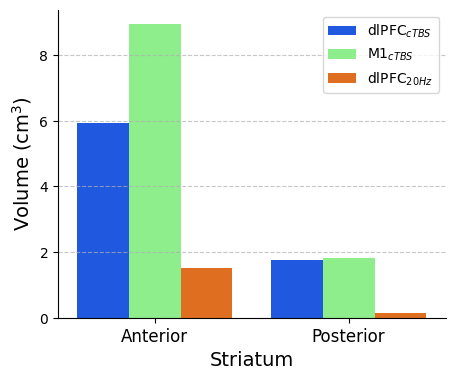

In [28]:
fig, ax = plt.subplots(figsize=(5,4))

g = sns.barplot(
    data=df, x='roi', y='volume', hue='group'
#     , order=('M1_cTBS', 'dlPFC_cTBS')
    , palette=palette
    , ax=ax
)
g.set_xlabel(r'Striatum', fontsize=14)
g.set_xticklabels([r'Anterior', r'Posterior'], fontsize=12)
g.set_ylabel(r'Volume (cm$^{3}$)', fontsize=14)
g.grid(axis='y', linestyle='--', alpha=0.7)
# g.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncol=1)
g.legend(loc='best')

# ## Bounding box
# bbox = g.get_position()
# rect = (0.4, 0.6, 0.55, 0.3) # (x0, y0, w, h)
# ax_insert = fig.add_axes(rect)
# nilearn.plotting.plot_roi(
#     img_roi
#     , display_mode='ortho', draw_cross=False
# #     , cut_coords=[0, 40, 10]
#     , axes=ax_insert
# )

sns.despine()

fig.savefig(
    '/home/sungbeenpark/Github/labs/GP/results/barplot.%s.cluster_volume.png'%glm
    , dpi=300, facecolor=[1,1,1,1]
    , bbox_inches = "tight"
)

---

/tmp/ipykernel_138137/632453462.py:8: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  print(np.unique(img_roi.get_data()))


[0 1 2]


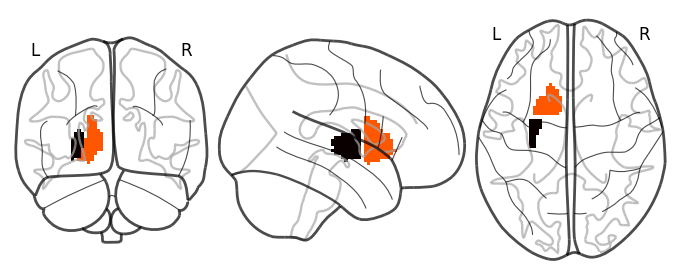

In [10]:
img_roi = nilearn.image.math_img(
    img1=img_roi_anterior
    , img2=img_roi_posterior
    , formula='img1 + 2*img2'
)
label_roi = ['Anterior', 'Posterior']

print(np.unique(img_roi.get_data()))
nilearn.plotting.plot_glass_brain(img_roi)

In [11]:
## `3dmaskave` 와 결과 일치하는 것 확인함.
masker = NiftiLabelsMasker(
    labels_img=img_roi
    , memory='/home/sungbeenpark/trash/nilearn_cashe', verbose=0
    , labels=label_roi
)
value_rois = masker.labels_img.get_fdata().astype(int)

In [12]:
list_fname = glob(join(dir_stat, 'AM/%s/%.1fs_shifted/GP??/Rew#1_Coef.nii'%(glm, shift)))

In [13]:
df = pd.DataFrame(columns=['subj', 'group', 'region', 'stim', 'roi', 'nvoxels', 'beta', 'shift'])

for fname in tqdm(list_fname):
    subj = fname.split('/')[-2]
    nn = subj[2:]
    group = 'DLPFC_cTBS' if nn in list_dlPFC_cTBS else ('M1_cTBS' if nn in list_M1_cTBS else ('DLPFC_20Hz' if nn in list_dlPFC_20Hz else 'invalid'))
    region = group.split('_')[0]
    stim = group.split('_')[1]
    group = r'%s$_{%s}$'%(region, stim)
    
    features = masker.fit_transform(fname)
    for jj, roi in enumerate(masker.labels):
        new_row = pd.Series(
            {
                'subj':subj, 'group':group, 'region':region, 'stim':stim
                , 'roi':roi, 'nvoxels':value_rois[value_rois==jj+1].astype(bool).sum()
                , 'shift':'%.1fs'%shift, 'beta':features[0][jj]
            }
        )
        df = pd.concat(
            [df, new_row.to_frame().T]
            , axis='index'
            , ignore_index=True
        )

100%|██████████| 46/46 [00:00<00:00, 57.50it/s]


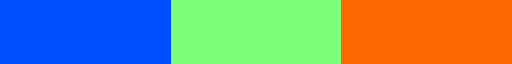

In [14]:
tmp = cm.jet(np.linspace(0.2, 0.8, 3))
palette = [colors.rgb2hex(rgb, keep_alpha=True) for rgb in tmp]

colors.ListedColormap(palette)

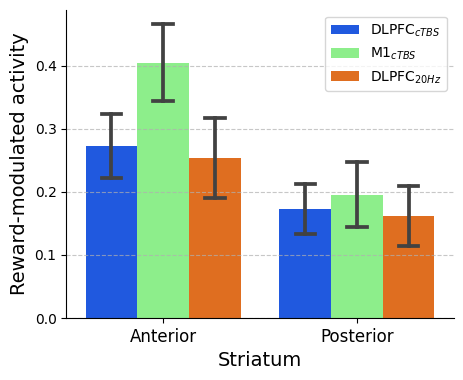

In [23]:
fig, ax = plt.subplots(figsize=(5,4))

g = sns.barplot(
    data=df, x='roi', y='beta', hue='group'
    , hue_order=(r'DLPFC$_{cTBS}$', r'M1$_{cTBS}$', r'DLPFC$_{20Hz}$')
    , palette=palette
    , errorbar='se', capsize=0.1
    , ax=ax
)
g.set_xlabel(r'Striatum', fontsize=14)
g.set_xticklabels([r'Anterior', r'Posterior'], fontsize=12)
g.set_ylabel(r'Reward-modulated activity', fontsize=14)
g.grid(axis='y', linestyle='--', alpha=0.7)
# # g.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncol=1)
g.legend(loc='best')

# ## Bounding box
# bbox = g.get_position()
# rect = (0.4, 0.6, 0.55, 0.3) # (x0, y0, w, h)
# ax_insert = fig.add_axes(rect)
# nilearn.plotting.plot_roi(
#     img_roi
#     , display_mode='ortho', draw_cross=False
# #     , cut_coords=[0, 40, 10]
#     , axes=ax_insert
# )

sns.despine()

In [17]:
s = '%.1fs'%shift
print('time shift = %s'%s)
g1, g2 = r'DLPFC$_{20Hz}$', r'M1$_{cTBS}$'
print("%s vs. %s"%(g1, g2))
for roi in label_roi:
    a = df[(df.group==g1)&(df.roi==roi)&(df['shift']==s)].beta
    b = df[(df.group==g2)&(df.roi==roi)&(df['shift']==s)].beta
    tval, pval = stats.ranksums(a,b,alternative='less')
    print("%s:"%roi, "%.4f (%s)"%(pval,convert_pvalue_to_asterisks(pval)))

time shift = 5.0s
DLPFC$_{20Hz}$ vs. M1$_{cTBS}$
Anterior: 0.0315 (*)
Posterior: 0.3290 (ns)


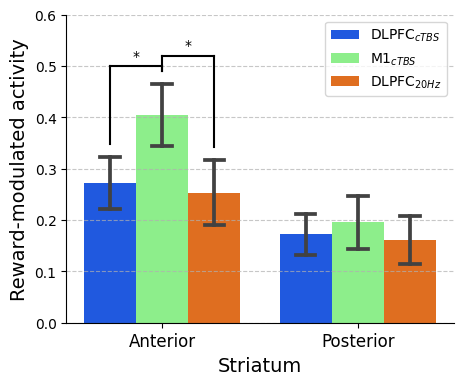

In [24]:
## dlPFC_cTBS vs. M1_cTBS
s = '%.1fs'%5
g1, g2 = r'DLPFC$_{cTBS}$', r'M1$_{cTBS}$'
roi = 'Anterior'

a = df[(df.group==g1)&(df.roi==roi)&(df['shift']==s)].beta
b = df[(df.group==g2)&(df.roi==roi)&(df['shift']==s)].beta
tval, pval = stats.ranksums(a,b,alternative='less')

N = len(label_roi)
x_m = 0
x1 = -0.265
x2 = 0
yUEdge = 0.5
yApart = 0.025
g.plot([x1, x1], [a.mean()+(a.sem()+yApart), yUEdge], 'k-')
g.plot([x2, x2], [b.mean()+(b.sem()+yApart), yUEdge], 'k-')
g.plot([x1, x2], [yUEdge, yUEdge], 'k-')
g.text(
    (x1+x2)*0.5, yUEdge+(0.02), convert_pvalue_to_asterisks(pval)
    , ha='center', va='center', rotation=0, size=10
)

## dlPFC_20Hz vs. M1_cTBS
s = '%.1fs'%5
g1, g2 = r'DLPFC$_{20Hz}$', r'M1$_{cTBS}$'
roi = 'Anterior'

a = df[(df.group==g1)&(df.roi==roi)&(df['shift']==s)].beta
b = df[(df.group==g2)&(df.roi==roi)&(df['shift']==s)].beta
tval, pval = stats.ranksums(a,b,alternative='less')

N = len(label_roi)
x_m = 0
x1 = 0.265
x2 = 0
yUEdge = 0.52
yApart = 0.025
g.plot([x1, x1], [a.mean()+(a.sem()+yApart), yUEdge], 'k-')
g.plot([x2, x2], [b.mean()+(b.sem()+yApart), yUEdge], 'k-')
g.plot([x1, x2], [yUEdge, yUEdge], 'k-')
g.text(
    (x1+x2)*0.5, yUEdge+(0.02), convert_pvalue_to_asterisks(pval)
    , ha='center', va='center', rotation=0, size=10
)
g.set_ylim(0, 0.6)

fig.savefig(
    '/home/sungbeenpark/Github/labs/GP/results/barplot.%s.%.1fs_shifted.beta_Coef.png'%(glm,shift)
    , dpi=300, facecolor=[1,1,1,1]
    , bbox_inches = "tight"
)

fig